In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


In [9]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다. 

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
output = embedding(raw_inputs)
print(output)

/tmp/ipykernel_647/3357816666.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

실행해 보니 에러가 발생합니다. 왜 그럴까요?

주의해야 할 점이 있습니다. Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다. raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5입니다.

Tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.

In [10]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [11]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index) # 위 예시에서 딕셔너리에 포함된 단어 개수는 10개
word_vector_dim = 4 # 그림과 같이 4차원의 워드벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                     output_dim = word_vector_dim, 
                                      mask_zero = True
                                     )

# Keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야
# Embedding 레리어의 input이 될 수 있습니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                    value = word_to_index['<PAD>'],
                                                       padding = 'post', maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.04949879  0.02807844  0.01123594  0.04528877]
  [-0.00212995  0.02362985  0.04472771  0.0396789 ]
  [-0.03146434  0.03639418  0.02529032 -0.02258196]
  [ 0.03948904 -0.0321246  -0.039543    0.04482882]
  [-0.00152764  0.01816037  0.00187601  0.03378614]]

 [[ 0.04949879  0.02807844  0.01123594  0.04528877]
  [-0.00212995  0.02362985  0.04472771  0.0396789 ]
  [ 0.0366716   0.0165385  -0.03793801  0.01041364]
  [ 0.04031559 -0.00578275  0.01933131  0.02178154]
  [-0.00152764  0.01816037  0.00187601  0.03378614]]

 [[ 0.04949879  0.02807844  0.01123594  0.04528877]
  [ 0.04269062  0.01492     0.00235023  0.01619664]
  [-0.00212995  0.02362985  0.04472771  0.0396789 ]
  [-0.03146434  0.03639418  0.02529032 -0.02258196]
  [ 0.00038718 -0.03332315 -0.02427818  0.02656325]]], shape=(3, 5, 4), dtype=float32)


/tmp/ipykernel_647/2532460319.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))


In [12]:
vocab_size = 10 # 어휘 사전의 크기. (10개의 단어)
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM 레이러를 사용. 이때 LSTM state벡터의 차원수는 8로 설정
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [13]:
vocab_size = 10 # 어휘 사전의 크기 (10단어)
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
vocab_size = 10 # 어휘 사전의 크기 (10개 단어)
word_vector_dim = 4 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.6.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [16]:
print(x_train[0]) # 1번째 리뷰 데이터
print("라벨 : ", y_train[0]) # 1번째 리뷰 데이터의 라벨
print("1번째 리뷰의 문장 길이 : ", len(x_train[0]))
print("2번째 리뷰의 문장 길이 : ", len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨 :  1
1번째 리뷰의 문장 길이 :  218
2번째 리뷰의 문장 길이 :  189


In [17]:
word_to_index = imdb.get_word_index()
index_to_word = {index : word for word, index in word_to_index.items()}
print(index_to_word[1]) # 'the' 가 출력됩니다.
print(word_to_index['the']) # 1이 출력됩니다.

the
1


In [18]:
# 실제 인코딩 인덱스는 제공된 word_to_index 기준으로 3씩 뒤로 밀려있습니다.
word_to_index = {k:(v+3) for k, v in word_to_index.items()}

# 처음 몇개 인덱스는 사전에 정의되어 있습니다.
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2 #unknown
word_to_index['<UNUSED>'] = 3

index_to_word[0] = '<PAD>'
index_to_word[1] = '<BOS>'
index_to_word[2] = '<UNK>'
index_to_word[3] = '<UNUSED>'

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1]) # '<BOS>' 출력
print(word_to_index['the']) # 4가 출력
print(index_to_word[4]) # 'the' 출력

<BOS>
4
the


In [19]:
print(get_decoded_sentence(x_train[0], index_to_word))
print("라벨 : ", y_train[0]) # 첫 번째 리뷰의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [20]:
total_data_text = list(x_train) + list(x_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이 평균 : ", np.mean(num_tokens))
print("문장 길이 최대 : ", np.max(num_tokens))
print("문장 길이 표준편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이 평균 :  234.75892
문장 길이 최대 :  2494
문장 길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다.


In [21]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                    value=word_to_index['<PAD>'],
                    padding='post', # 혹은 'pre'
                    maxlen = maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                    value=word_to_index['<PAD>'],
                    padding = 'post', # 혹은 'pre'
                    maxlen = maxlen)

print(x_train.shape)

(25000, 580)


## IMDB 영화리뷰 감성분석 - 딥러닝 모델 설계와 훈련

In [22]:
vocab_size = 10000 # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 16 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 설계. 위에서 만든 모델을 사용해봅시다.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [23]:
# validation set 10000건 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [24]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

epochs = 20 

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/20
30/30 [==============================] - 20s 30ms/step - loss: 0.6930 - accuracy: 0.5113 - val_loss: 0.6925 - val_accuracy: 0.5033
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6871 - accuracy: 0.5715 - val_loss: 0.6836 - val_accuracy: 0.5618
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6440 - accuracy: 0.7573 - val_loss: 0.5782 - val_accuracy: 0.7986
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4451 - accuracy: 0.8443 - val_loss: 0.3604 - val_accuracy: 0.8515
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2664 - accuracy: 0.8990 - val_loss: 0.3086 - val_accuracy: 0.8702
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1828 - accuracy: 0.9356 - val_loss: 0.3073 - val_accuracy: 0.8732
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1365 - accuracy: 0.9547 - val_loss: 0.3286 - val_accuracy: 0.8705
Epoch 8/20
3

In [25]:
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

782/782 - 1s - loss: 0.6925 - accuracy: 0.8450
[0.6924824118614197, 0.8449599742889404]


In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


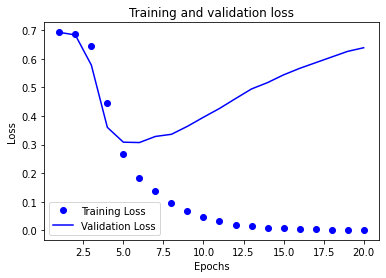

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

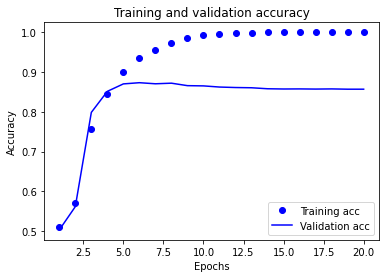

In [28]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.01631728,  0.0355123 , -0.01784502, -0.04364004,  0.07624035,
        0.0441875 ,  0.02565757,  0.06309228,  0.04683638, -0.05271655,
        0.02481499,  0.0455235 , -0.07764395,  0.00908102, -0.07027322,
       -0.03542773], dtype=float32)

In [32]:
word_vectors.similar_by_word("love")

[('raw', 0.8804479241371155),
 ('reveal', 0.8623505234718323),
 ('soles', 0.8604695796966553),
 ('fun', 0.8603529334068298),
 ('48', 0.8576575517654419),
 ('novak', 0.8524704575538635),
 ('well', 0.8474664688110352),
 ('style', 0.8375077247619629),
 ('loved', 0.822443425655365),
 ('pacino', 0.8158224821090698)]

In [33]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [34]:
# 메모리를 다소 많이 소비하는 작업이니 유의하세요.
word2vec.similar_by_word('love')

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('Ilove', 0.5702950954437256),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063)]

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [36]:
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [37]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 5s 86ms/step - loss: 0.6985 - accuracy: 0.5255 - val_loss: 0.6771 - val_accuracy: 0.5804
Epoch 2/20
30/30 [==============================] - 2s 72ms/step - loss: 0.6471 - accuracy: 0.6418 - val_loss: 0.6331 - val_accuracy: 0.6310
Epoch 3/20
30/30 [==============================] - 2s 72ms/step - loss: 0.5346 - accuracy: 0.7611 - val_loss: 0.4750 - val_accuracy: 0.7832
Epoch 4/20
30/30 [==============================] - 2s 72ms/step - loss: 0.3646 - accuracy: 0.8557 - val_loss: 0.3415 - val_accuracy: 0.8585
Epoch 5/20
30/30 [==============================] - 2s 71ms/step - loss: 0.2601 - accuracy: 0.8997 - val_loss: 0.3139 - val_accuracy: 0.8682
Epoch 6/20
30/30 [==============================] - 2s 72ms/step - loss: 0.1913 - accuracy: 0.9341 - val_loss: 0.3075 - val_accuracy: 0.8733
Epoch 7/20
30/30 [==============================] - 2s 72ms/step - loss: 0.1370 - accuracy: 0.9601 - val_loss: 0.3011 - val_accuracy: 0.8772
Epoch 8/20
30

In [38]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.5023 - accuracy: 0.8620
[0.5023434162139893, 0.8619599938392639]


# 회고

### Word2Vec를 이용하여 Pre-Trained된 Word2Vec Embedding 모델을 사용하였지만 이 모델에서도 유일하게 LSTM 만 85%를 넘을 수 있었다.
### 아직 머신러닝이나 딥러닝의 모델을 설계하는 정확한 이해 없이 정확도를 올리려고 하니까 너무 어려운 것 같다.
### 물론 아직 배우기 시작하는 단계라서 어쩔 수 없다고 생각은 하지만 모델 설계에 대한 공부도 따로 해야겠다.
### 일단 이미지 인식과 자연어 처리 둘 다 경험은 해봤으니 앞으로 어떤 분야에 집중을 할지 고민해봐야겠다.
### 이미지 인식를 활용하여 보다 많은 이미지를 변환해보고 싶다는 욕심이 생겼고, 요즘 핫한 Chatgpt도 자연어 처리를 이용한 AI여서 관심을 놓을수가 없었다.
### 점점 학습과정들이 어려워 지는 것같아 걱정이 되는 한편 더욱더 열심히 노력해야 겠다는 생각이 들었다.